# 1. Introdução
------
Este notebook tem por objetivo ensinar como utilizar a biblioteca do GPA, além de apresentar alguns testes de matrizes fundamentais. 


Rode a célula a seguir, caso esteja utilizando o colab

In [1]:
!pip install git+https://github.com/rsautter/GPA

^C


A célula a seguir invoca as bibliotecas de manipulação de vetores, plotagem e o próprio GPA 

In [1]:
import GPA
import matplotlib.pyplot as plt
import numpy as np

from matplotlib import colors
import matplotlib.patches as mpatches

# 2. Utilizando o GPA
------
O GPA foi implementado como um objeto que analisa matrizes do tipo float de 32 bits. Parte do algoritmo consiste na detecção de simetrias no padrão, nesta implementação foi adotado a simetria concêntrica/rotacional. Neste tipo de simetria vetores que estão equidistantes ao centro padrão são comparados entre si. Caso exista ao menos um vetor que a soma com o , então este conjunto de vetores é dito simétrico. 

A figura a seguir mostra um exemplo do processo de detecção de simetria concêntrica, o círculo mostra uma determinada distância avaliada. Neste padrão todos os vetores são simétricos, pois para cada vetor existe um outro vetor a 180º em relação ao centro, com módulo igual e fase oposta.

<img src='https://raw.githubusercontent.com/rsautter/GPA/master/Figures/Remotion.png'>

Há um parâmetro de tolerância que é fornecido ao método construtor do GPA, para avaliar se dois pares de vetores são simétricos. No exemplo a seguir, a tolerância é 0.08, porém qualquer medida entre zero e um pode ser considerada. Este parâmetro determina a partir do maior vetor no padrão a ser analisado qual a tolerância do algoritmo de detecção de simetria.

In [2]:
ga = GPA.GPA(0.08)
ga.version()

b'GPA - 3.2'

O dado a ser analisado deve ser um array da biblioteca numpy e do tipo float, caso contrário ocorrerá um erro.

In [3]:
mat = [[0,0,0],
       [0,1,0],
       [0,0,0]]
mat = np.array(mat).astype(np.float)

O método 'evaluate' realiza a medida dos momentos do campo gradiente. Há três parâmetros:

 - mat - A matriz de entrada do tipo float
 - moment - Lista de momentos do campo gradiente a serem medidos ('G1','G2','G3' ou 'G4')
 - symmetrycalGrad - Determina se a medida será realizada sobre o campo simétrico, codificado como:
    - 'S'  - campo simétricos
    - 'A'  - campo assimétrico
    - 'F'  - campo gradiente completo


Por padrão os parâmetros são:

    moment = ['G2']
    symmetrycalGrad = 'A'

Neste exemplo a matriz é completamente simétrica.

In [4]:
moments = ga(mat, moment=['G1','G2','G3'],symmetrycalGrad='A')
moments = {key : round(moments[key], 3) for key in moments}
print("Momentos do campo gradiente assimétrico:",moments)

moments = ga(mat, moment=['G1','G2','G3'],symmetrycalGrad='S')
moments = {key : round(moments[key], 3) for key in moments}
print("Momentos do campo gradiente simétrico:",moments)

moments = ga(mat, moment=['G1','G2','G3'],symmetrycalGrad='F')
moments = {key : round(moments[key], 3) for key in moments}
print("Momentos do campo gradiente completo:",moments)

Momentos do campo gradiente assimétrico: {'G1': 0.0, 'G2': 0.0, 'G3': 0.0}
Momentos do campo gradiente simétrico: {'G1': 0.25, 'G2': 2.0, 'G3': 1.0}
Momentos do campo gradiente completo: {'G1': 1.222, 'G2': 2.0, 'G3': 1.333}


## 2.1. Momentos do Campo Gradiente

###  Primeiro Momento  do Campo Gradiente ($G_1$)
O primeiro momento do campo gradiente é calculado a partir da triangulação de Delaunay. A medida é a razão entre o número de conexões ($N_C$) em relação ao número de vetores ($N_V$). Por meio de testes [(ROSA et. al., 1999)](https://www.worldscientific.com/doi/abs/10.1142/S0129183199000103), foi constatado que a medida está limitada ao intervalo \[0, 2\[.   

$$G_1 = {N_C-N_V \over N_V} = {N_C \over N_V}-1$$

Não há impedimentos de $G_1$ quanto a classificação do campo gradiente em relação a simetria, o que não é observado para os casos do segundo e terceiro momentos do campo gradiente.

### Segundo Momento do Campo Gradiente Assimétrico ($G_2$)
O segundo momento do campo gradiente é uma medida que relacionada a proporção de vetores assimétricos(${V_A / V}$) e a variabilidade dos módulos ($ {|\sum v^A| / \sum|v^A|}$) . Esta medida foi ajustada ao intervalo $[0,2]$, conforme descrito por [Barchi, et.al.,(2017)](https://arxiv.org/abs/1705.06818), com o intuito de comparar aos demais momentos do campo gradiente.

$$ G_2 = {V_A \over V} \left( 2 - {|\sum v^A|\over \sum|v^A|}\right)$$

### Segundo Momento do Campo Gradiente Simétrico ($G^S_2$)
A medida utilizada no segundo momento do campo gradiente assimétrico não pode ser utilizada para o caso do campo simétrico. O somatório de vetores simétricos é sempre zero ($|\sum v^S| = 0$), e portanto a medida seria apenas uma proporção de vetores. Como alternativa, é proposto a equação a seguir, onde $||v^S_{i,j}||$ é o módulo de um determinado vetor simétrico, normalizado pelo maior módulo de vetor simétrico.

$$G^S_2 = -2 \sum ||v^S||ln\left(||v^S||\right)$$
 
###  Terceiro Momento do Campo Gradiente ($G_3$)

Toda medida realizada sobre o conjunto de fases de um campo gradiente pertence ao terceiro momento do campo gradiente, segundo formalismo da análise de padrões do campo gradiente. Uma medida possível é a relação entre o centro do padrão e as fases. O ângulo entre o centro da imagem ($\phi_i$) é comparado  com o respectivo elementodo campo de fases ($\theta_i$), conforme a equação a seguir.   

$$G_3 = {V_A \over V} + {1 \over 2V_A}\sum_i^{V_A} [cos(\theta_i)cos(\phi_i)+sin(\theta_i)sin(\phi_i)+1]$$

A medida proposta pode ser vista no espaço como o produto interno entre os dois vetores unitários $u$ e $v$, tal que  $u = (cos(\phi),sin(\phi))$ e $v = (cos(\theta),sin(\theta))$. Por definição o produto interno é:

$$u.v = |u||v|cos(\gamma) = cos(\gamma)$$

A figura a seguir mostra a relação entre os vetores $u$ e $v$ e a resposta do produto interno. Ao somar 1 e dividir por 2, a medida do produto interno indica o grau de alinhamento entre $\phi$ e $\theta$.  
<center>
<img src='https://raw.githubusercontent.com/rsautter/GPA/master/Figures/G3Exp.png'>
</center>



## 2.2. Plot


O plot a seguir mostra a matriz de amplitudes, o campo gradiente e a classificação dos vetores quanto a simetria. Infelizmente, para o caso de um padrão somente com vetores indeterminados, como uma matriz constante, a função [quiver](https://matplotlib.org/3.1.1/api/_as_gen/matplotlib.pyplot.quiver.html) não funciona propriamente.

Outro aspecto importante é que por padrão matrizes numpy possuem origem no canto superior esquerdo, enquanto o padrão da matplotlib a origem é o canto inferior esquerdo.

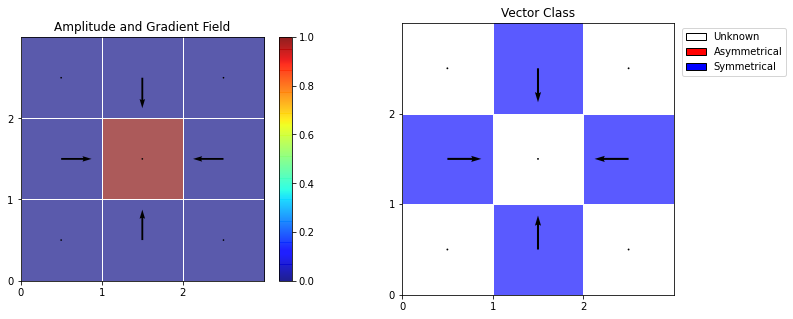

In [5]:
def plotGPAVecClass(mat,ga):
    plt.figure(figsize=(12,5))
    plt.subplot(1,2,1)
    im = plt.imshow(mat,origin='lower',alpha=0.65,cmap = 'jet',extent=[0,len(mat),0,len(mat)])
    plt.colorbar(im,shrink=0.9)
    meshgrid = np.meshgrid(np.arange(0,len(mat))+.5,np.arange(0,len(mat))+.5)
    plt.quiver(meshgrid[0],meshgrid[1],ga.gradient_dx,ga.gradient_dy)
    plt.gca().set_xticks(np.arange(0, len(mat)), minor=False)
    plt.gca().set_yticks(np.arange(0,  len(mat)), minor=False)
    plt.gca().grid(which='major', color='w', linestyle='-', linewidth=1)
    plt.title("Amplitude and Gradient Field")
    plt.subplot(1,2,2)
    classificationMap = np.array(ga.unknownP) + 3*np.array(ga.asymmetricalP) + 5*np.array(ga.symmetricalP) 
    
    cmap = colors.ListedColormap(['white','red','blue'])
    norm = colors.BoundaryNorm([0,2,5,6], cmap.N)
    plt.imshow(classificationMap,origin='lower',cmap=cmap,extent=[0,len(mat),0,len(mat)],alpha=0.65,norm=norm)
    plt.quiver(meshgrid[0],meshgrid[1],ga.gradient_dx,ga.gradient_dy)
    plt.gca().set_xticks(np.arange(0, len(mat)), minor=False)
    plt.gca().set_yticks(np.arange(0,  len(mat)), minor=False)
    plt.gca().grid(which='major', color='w', linestyle='-', linewidth=1)
    legendColors = [mpatches.Patch(facecolor='white', label='Unknown', edgecolor='k'),
                    mpatches.Patch(facecolor='red', label='Asymmetrical', edgecolor='k'),
                    mpatches.Patch(facecolor='blue', label='Symmetrical', edgecolor='k')]
    plt.legend(handles=legendColors, bbox_to_anchor=(1.01, 1), loc='upper left')
    plt.title("Vector Class")
    plt.show()
    
plotGPAVecClass(mat,ga)

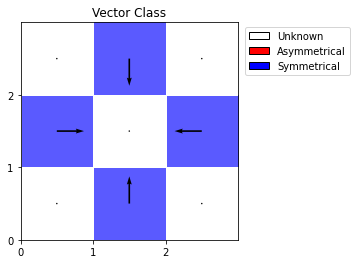

In [6]:
def plotGPAVecClassOnly(ga):
    
    plt.figure()
    meshgrid = np.meshgrid(np.arange(0,len(mat))+.5,np.arange(0,len(mat))+.5)
    classificationMap = np.array(ga.unknownP) + 3*np.array(ga.asymmetricalP) + 5*np.array(ga.symmetricalP) 
    cmap = colors.ListedColormap(['white','red','blue'])
    norm = colors.BoundaryNorm([0,2,5,6], cmap.N)
    plt.imshow(classificationMap,origin='lower',cmap=cmap,extent=[0,len(mat),0,len(mat)],alpha=0.65,norm=norm)
    plt.quiver(meshgrid[0],meshgrid[1],ga.gradient_dx,ga.gradient_dy)
    plt.gca().set_xticks(np.arange(0, len(mat)), minor=False)
    plt.gca().set_yticks(np.arange(0,  len(mat)), minor=False)
    plt.gca().grid(which='major', color='w', linestyle='-', linewidth=1)
    legendColors = [mpatches.Patch(facecolor='white', label='Unknown', edgecolor='k'),
                    mpatches.Patch(facecolor='red', label='Asymmetrical', edgecolor='k'),
                    mpatches.Patch(facecolor='blue', label='Symmetrical', edgecolor='k')]
    plt.legend(handles=legendColors, bbox_to_anchor=(1.01, 1), loc='upper left')
    plt.title("Vector Class")
    plt.show()
    
plotGPAVecClassOnly(ga)

# 3. Matrizes Fundamentais
------

O conceito original de matriz fundamental foi estabelecido por [Rosa et. al., (1999)](https://www.worldscientific.com/doi/abs/10.1142/S0129183199000103), como a menor matriz que possui um elemento central, ou seja uma matriz fundamental 2D de tamanho 3x3. Este tipo de padrão é importante para entender os algoritmos propostos e validar a implementação.


Neste sentido, são apresentados quatro categorias de matrizes fundamentais:

    - simétricas
    - assimétricas
    - indeterminado
    - misto

## 3.1. Simétrica

In [7]:
mat = [[0,2,0],
       [2,1,2],
       [0,2,0]]
mat = np.array(mat).astype(np.float)
  
moments = ga(mat, moment=['G1','G2','G3'],symmetrycalGrad='A')
moments = {key : round(moments[key], 3) for key in moments}
print("Momentos do campo gradiente assimétrico:",moments)

moments = ga(mat, moment=['G1','G2','G3'],symmetrycalGrad='S')
moments = {key : round(moments[key], 3) for key in moments}
print("Momentos do campo gradiente simétrico:",moments)

moments = ga(mat, moment=['G1','G2','G3'],symmetrycalGrad='F')
moments = {key : round(moments[key], 3) for key in moments}
print("Momentos do campo gradiente completo:",moments)

Momentos do campo gradiente assimétrico: {'G1': 0.0, 'G2': 0.0, 'G3': 0.0}
Momentos do campo gradiente simétrico: {'G1': 0.6, 'G2': 1.886, 'G3': 1.5}
Momentos do campo gradiente completo: {'G1': 0.6, 'G2': 2.0, 'G3': 1.556}


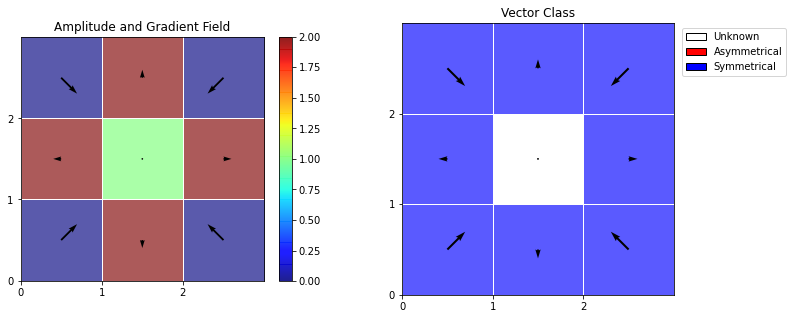

In [8]:
plotGPAVecClass(mat,ga)

Outra tipo de dado que é aceito pela ferramenta é o campo gradiente já calculado.

In [9]:
dx = [[0,1,0],
       [-1,0,1],
       [0,-1,0]]
dx = np.array(dx,dtype=np.float)

dy = [[1,0,-1],
       [2,0,-2],
       [1,0,-1]]
dy = np.array(dy,dtype=np.float)

moments = ga(gx=dx,gy=dy, moment=['G1','G2','G3'],symmetrycalGrad='A')
moments = {key : round(moments[key], 3) for key in moments}
print("Momentos do campo gradiente assimétrico:",moments)

moments = ga(gx=dx,gy=dy, moment=['G1','G2','G3'],symmetrycalGrad='S')
moments = {key : round(moments[key], 3) for key in moments}
print("Momentos do campo gradiente simétrico:",moments)

moments = ga(gx=dx,gy=dy, moment=['G1','G2','G3'],symmetrycalGrad='F')
moments = {key : round(moments[key], 3) for key in moments}
print("Momentos do campo gradiente completo:",moments)

Momentos do campo gradiente assimétrico: {'G1': 0.0, 'G2': 0.0, 'G3': 0.0}
Momentos do campo gradiente simétrico: {'G1': 0.875, 'G2': 1.928, 'G3': 1.556}
Momentos do campo gradiente completo: {'G1': 1.0, 'G2': 2.0, 'G3': 1.605}


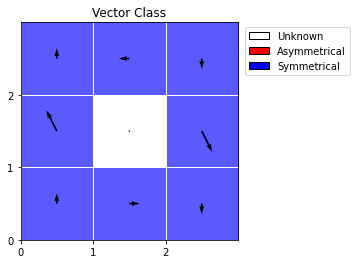

In [10]:
plotGPAVecClassOnly(ga)

In [11]:
mat = [[0,3,0],
       [2,7,2],
       [0,3,0]]
mat = np.array(mat).astype(np.float)
  
moments = ga(mat, moment=['G1','G2','G3'],symmetrycalGrad='A')
moments = {key : round(moments[key], 3) for key in moments}
print("Momentos do campo gradiente assimétrico:",moments)

moments = ga(mat, moment=['G1','G2','G3'],symmetrycalGrad='S')
moments = {key : round(moments[key], 3) for key in moments}
print("Momentos do campo gradiente simétrico:",moments)

moments = ga(mat, moment=['G1','G2','G3'],symmetrycalGrad='F')
moments = {key : round(moments[key], 3) for key in moments}
print("Momentos do campo gradiente completo:",moments)

Momentos do campo gradiente assimétrico: {'G1': 0.0, 'G2': 0.0, 'G3': 0.0}
Momentos do campo gradiente simétrico: {'G1': 0.833, 'G2': 1.991, 'G3': 1.005}
Momentos do campo gradiente completo: {'G1': 1.0, 'G2': 2.0, 'G3': 1.115}


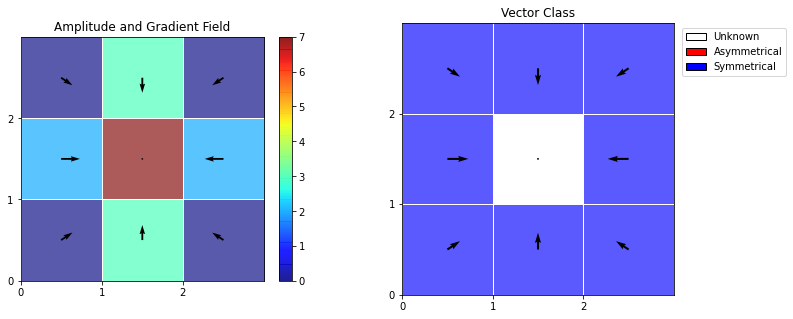

In [12]:
plotGPAVecClass(mat,ga)

## 3.2. Assimétrico

In [13]:
mat = [[3,6,4],
       [6,0,5],
       [4,7,4]]

mat = np.array(mat).astype(np.float)
  
moments = ga(mat, moment=['G1','G2','G3'],symmetrycalGrad='A')
moments = {key : round(moments[key], 3) for key in moments}
print("Momentos do campo gradiente assimétrico:",moments)

moments = ga(mat, moment=['G1','G2','G3'],symmetrycalGrad='S')
moments = {key : round(moments[key], 3) for key in moments}
print("Momentos do campo gradiente simétrico:",moments)


moments = ga(mat, moment=['G1','G2','G3'],symmetrycalGrad='F')
moments = {key : round(moments[key], 3) for key in moments}
print("Momentos do campo gradiente completo:",moments)

Momentos do campo gradiente assimétrico: {'G1': 1.222, 'G2': 1.921, 'G3': 1.47}
Momentos do campo gradiente simétrico: {'G1': 0.0, 'G2': 0.0, 'G3': 0.0}
Momentos do campo gradiente completo: {'G1': 1.222, 'G2': 1.921, 'G3': 1.47}


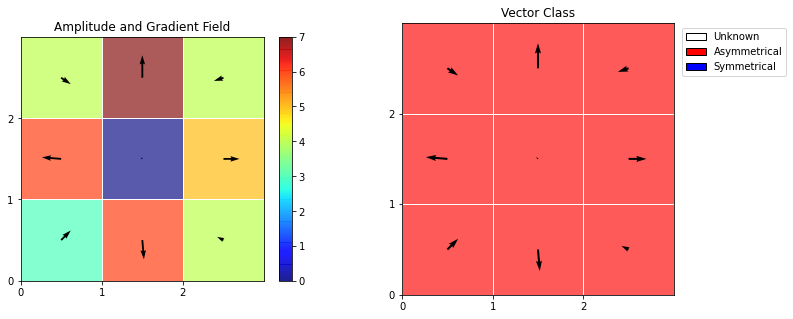

In [14]:
plotGPAVecClass(mat,ga)

In [15]:
dx = [[2,1,0],
       [-1,0,1],
       [0,1,0]]
dx = np.array(dx,dtype=np.float)

dy = [[1,0,2],
       [-2,0.5,3],
       [-1,0,-1]]
dy = np.array(dy,dtype=np.float)

moments = ga(gx=dx,gy=dy, moment=['G1','G2','G3'],symmetrycalGrad='A')
moments = {key : round(moments[key], 3) for key in moments}
print("Momentos do campo gradiente assimétrico:",moments)

moments = ga(gx=dx,gy=dy, moment=['G1','G2','G3'],symmetrycalGrad='S')
moments = {key : round(moments[key], 3) for key in moments}
print("Momentos do campo gradiente simétrico:",moments)


moments = ga(gx=dx,gy=dy, moment=['G1','G2','G3'],symmetrycalGrad='F')
moments = {key : round(moments[key], 3) for key in moments}
print("Momentos do campo gradiente completo:",moments)

Momentos do campo gradiente assimétrico: {'G1': 1.111, 'G2': 1.666, 'G3': 1.372}
Momentos do campo gradiente simétrico: {'G1': 0.0, 'G2': 0.0, 'G3': 0.0}
Momentos do campo gradiente completo: {'G1': 1.111, 'G2': 1.666, 'G3': 1.372}


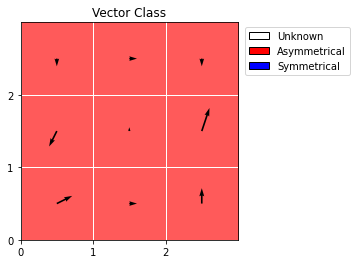

In [16]:
plotGPAVecClassOnly(ga)

## 3.3. Misto

In [17]:
mat = [[3,6,5],
       [6,0,6],
       [4,6,3]]
mat = np.array(mat).astype(np.float)
  
moments = ga(mat, moment=['G1','G2','G3'],symmetrycalGrad='A')
moments = {key : round(moments[key], 3) for key in moments}
print("Momentos do campo gradiente assimétrico:",moments)

moments = ga(mat, moment=['G1','G2','G3'],symmetrycalGrad='S')
moments = {key : round(moments[key], 3) for key in moments}
print("Momentos do campo gradiente simétrico:",moments)


moments = ga(mat, moment=['G1','G2','G3'],symmetrycalGrad='F')
moments = {key : round(moments[key], 3) for key in moments}
print("Momentos do campo gradiente completo:",moments)

Momentos do campo gradiente assimétrico: {'G1': 0.833, 'G2': 1.444, 'G3': 1.414}
Momentos do campo gradiente simétrico: {'G1': 0.0, 'G2': 2.0, 'G3': 0.25}
Momentos do campo gradiente completo: {'G1': 1.125, 'G2': 1.943, 'G3': 1.554}


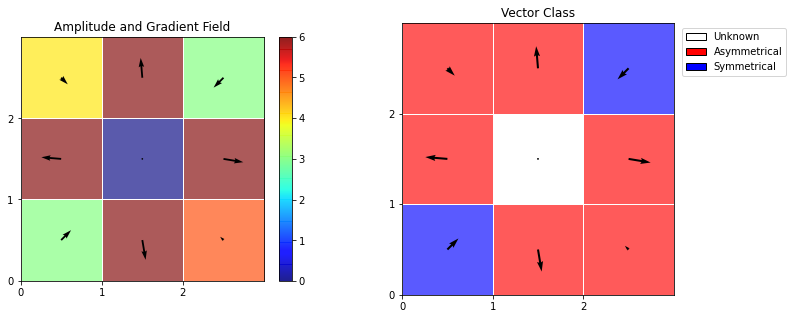

In [18]:
plotGPAVecClass(mat,ga)

In [19]:
mat = [[0,0,0],
       [2,0,2],
       [0,2,0]]
mat = np.array(mat).astype(np.float)

  
moments = ga(mat, moment=['G1','G2','G3'],symmetrycalGrad='A')
moments = {key : round(moments[key], 3) for key in moments}
print("Momentos do campo gradiente assimétrico:",moments)

moments = ga(mat, moment=['G1','G2','G3'],symmetrycalGrad='S')
moments = {key : round(moments[key], 3) for key in moments}
print("Momentos do campo gradiente simétrico:",moments)

moments = ga(mat, moment=['G1','G2','G3'],symmetrycalGrad='F')
moments = {key : round(moments[key], 3) for key in moments}
print("Momentos do campo gradiente completo:",moments)

Momentos do campo gradiente assimétrico: {'G1': 0.6, 'G2': 1.322, 'G3': 1.049}
Momentos do campo gradiente simétrico: {'G1': 0.0, 'G2': 2.0, 'G3': 1.25}
Momentos do campo gradiente completo: {'G1': 1.125, 'G2': 1.82, 'G3': 1.477}


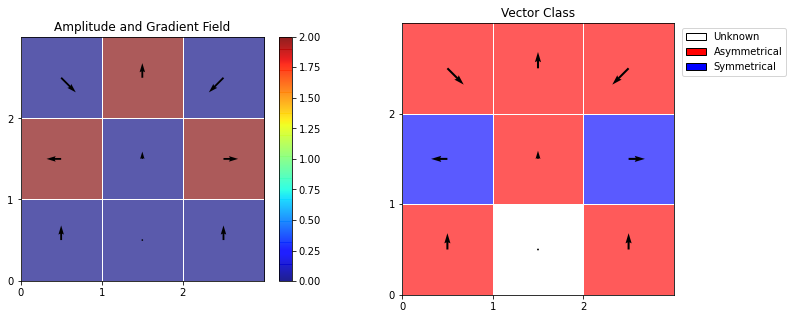

In [20]:
plotGPAVecClass(mat,ga)

## 3.4. Indeterminado

In [22]:
mat = [[0,0,0],
       [0,0,0],
       [0,0,0]]
mat = np.array(mat).astype(np.float)

  
moments = ga(mat, moment=['G1','G2','G3'],symmetrycalGrad='A')
moments = {key : round(moments[key], 3) for key in moments}
print("Momentos do campo gradiente assimétrico:",moments)

moments = ga(mat, moment=['G1','G2','G3'],symmetrycalGrad='S')
moments = {key : round(moments[key], 3) for key in moments}
print("Momentos do campo gradiente simétrico:",moments)


moments = ga(mat, moment=['G1','G2','G3'],symmetrycalGrad='F')
moments = {key : round(moments[key], 3) for key in moments}
print("Momentos do campo gradiente completo:",moments)


Momentos do campo gradiente assimétrico: {'G1': 0.0, 'G2': 0.0, 'G3': 0.0}
Momentos do campo gradiente simétrico: {'G1': 0.0, 'G2': 0.0, 'G3': 0.0}
Momentos do campo gradiente completo: {'G1': 0.778, 'G2': 2.0, 'G3': 1.556}


# Referências

[1] Rosa, Reinaldo R., A. S. Sharma, and J. A. Valdivia. "Characterization of asymmetric fragmentation patterns in spatially extended systems." International Journal of Modern Physics C 10.01 (1999): 147-163.

[2] Barchi, P. H., et al. "Improving galaxy morphology with machine learning." arXiv preprint arXiv:1705.06818 (2017).

### Extra - Plot

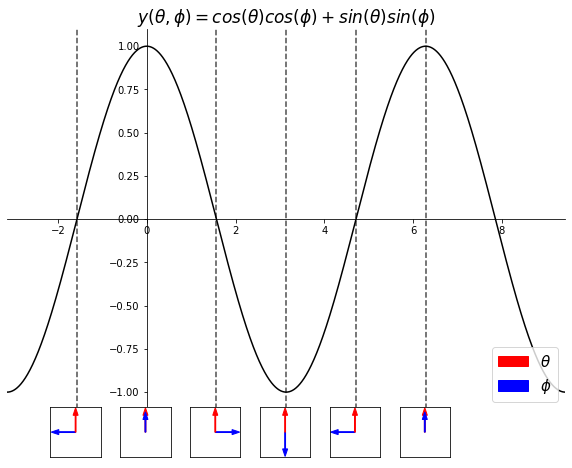

In [ ]:

fig = plt.figure(figsize=(10,7))

ax = plt.subplot(1,1,1)
x = np.linspace(-np.pi,3*np.pi,2000)
y = np.cos(x)
plt.plot(x,y,color='k')
plt.xlim(-np.pi,3*np.pi)

ax.spines['left'].set_position('zero')
ax.spines['right'].set_color('none')

ax.spines['bottom'].set_position('zero')
ax.spines['top'].set_color('none')

plt.axvline(-np.pi/2,c='k',ls='--',alpha=0.7)
plt.axvline(np.pi,c='k',ls='--',alpha=0.7)
plt.axvline(np.pi/2,c='k',ls='--',alpha=0.7)
plt.axvline(2*np.pi,c='k',ls='--',alpha=0.7)
plt.axvline(3*np.pi/2,c='k',ls='--',alpha=0.7)
plt.title(r'$y(\theta,\phi) = cos(\theta)cos(\phi)+sin(\theta)sin(\phi)$',fontsize=17)


theta = mpatches.Patch(color='red', label=r'$\theta$')
phi = mpatches.Patch(color='blue', label=r'$\phi$')
plt.legend(handles=[theta,phi],loc='lower right',fontsize=15)


fig.add_axes([0.185,0.03,0.07,0.1])
plt.arrow(0,0,-1,0,width=0.05,head_width=0.3,color='blue')
plt.arrow(0,0,0,1,width=0.05,head_width=0.3,color='red')
plt.xlim(-1.5,1.5)
plt.ylim(-1.5,1.5)
plt.xticks([])
plt.yticks([])

delta = 0.097
fig.add_axes([0.185+delta,0.03,0.07,0.1])
plt.arrow(0,0,0,1,width=0.05,head_width=0.3,color='red')
plt.arrow(0,0,0,0.75,width=0.05,head_width=0.3,color='blue')

plt.xlim(-1.5,1.5)
plt.ylim(-1.5,1.5)
plt.xticks([])
plt.yticks([])

fig.add_axes([0.185+2*delta,0.03,0.07,0.1])
plt.arrow(0,0,1,0,width=0.05,head_width=0.3,color='blue')
plt.arrow(0,0,0,1,width=0.05,head_width=0.3,color='red')
plt.xlim(-1.5,1.5)
plt.ylim(-1.5,1.5)
plt.xticks([])
plt.yticks([])

fig.add_axes([0.185+3*delta,0.03,0.07,0.1])
plt.arrow(0,0,0,-1,width=0.05,head_width=0.3,color='blue')
plt.arrow(0,0,0,1,width=0.05,head_width=0.3,color='red')
plt.xlim(-1.5,1.5)
plt.ylim(-1.5,1.5)
plt.xticks([])
plt.yticks([])

fig.add_axes([0.185+4*delta,0.03,0.07,0.1])
plt.arrow(0,0,-1,0,width=0.05,head_width=0.3,color='blue')
plt.arrow(0,0,0,1,width=0.05,head_width=0.3,color='red')
plt.xlim(-1.5,1.5)
plt.ylim(-1.5,1.5)
plt.xticks([])
plt.yticks([])

fig.add_axes([0.185+5*delta,0.03,0.07,0.1])
plt.arrow(0,0,0,1,width=0.05,head_width=0.3,color='red')
plt.arrow(0,0,0,0.75,width=0.05,head_width=0.3,color='blue')

plt.xlim(-1.5,1.5)
plt.ylim(-1.5,1.5)
plt.xticks([])
plt.yticks([])

mpatches
#ax.grid()

plt.show()

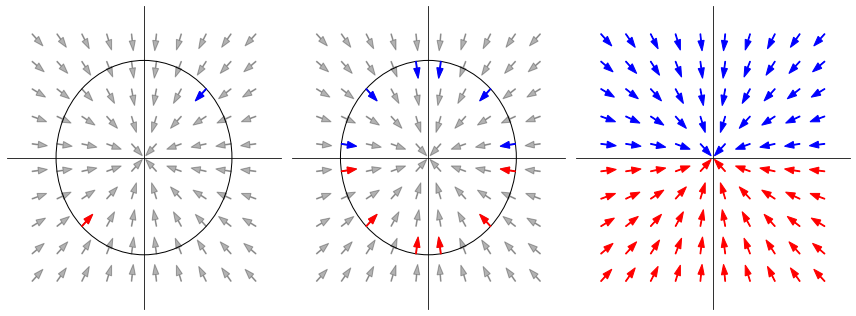

In [ ]:
n = 10
center = n//2-0.5
inverseDistanceW = 4
alpha = 0.3

plt.figure(figsize=(12,4.5))

plt.subplot(1,3,1)

for x in range(10):
  for y in range(10):
    d = inverseDistanceW*np.sqrt((x-center)**2+ (y-center)**2)+0.1
    dx,dy = center-x,center-y
    dx,dy = dx/d,dy/d
    plt.arrow(x,y,dx,dy,width=0.03,head_width=0.25,color='black',alpha=alpha)

x,y = 2,2
d = inverseDistanceW*np.sqrt((x-center)**2+ (y-center)**2)+0.1
dx,dy = center-x,center-y
dx,dy = dx/d,dy/d
plt.arrow(x,y,dx,dy,width=0.03,head_width=0.25,color='red',alpha=1)

x,y = 7,7
d = inverseDistanceW*np.sqrt((x-center)**2+ (y-center)**2)+0.1
dx,dy = center-x,center-y
dx,dy = dx/d,dy/d
plt.arrow(x,y,dx,dy,width=0.03,head_width=0.25,color='blue',alpha=1)

circle = plt.Circle((center, center), np.sqrt((x-center)**2+ (y-center)**2), color='k',fill=False)
ax = plt.gca()
ax.add_patch(circle)

plt.xlim(-1,10)
plt.ylim(-1,10)

ax.spines['left'].set_position(('data', center))
ax.spines['right'].set_color('none')

ax.spines['bottom'].set_position(('data', center))
ax.spines['top'].set_color('none')

plt.xticks([])
plt.yticks([])

'''
Mesma distancia
'''
dtarget = inverseDistanceW*np.sqrt((x-center)**2+ (y-center)**2)+0.1
plt.subplot(1,3,2)
for x in range(10):
  for y in range(10):
    d = inverseDistanceW*np.sqrt((x-center)**2+ (y-center)**2)+0.1
    dx,dy = center-x,center-y
    dx,dy = dx/d,dy/d
    plt.arrow(x,y,dx,dy,width=0.03,head_width=0.25,color='black',alpha=alpha)
    if np.abs(d-dtarget) <0.3:
      if(y<center):
        plt.arrow(x,y,dx,dy,width=0.03,head_width=0.25,color='red',alpha=1)
      else:
        plt.arrow(x,y,dx,dy,width=0.03,head_width=0.25,color='blue',alpha=1)

x,y = 7,7
circle = plt.Circle((center, center), np.sqrt((x-center)**2+ (y-center)**2), color='k',fill=False)
ax = plt.gca()
ax.add_patch(circle)

plt.xlim(-1,10)
plt.ylim(-1,10)

ax.spines['left'].set_position(('data', center))
ax.spines['right'].set_color('none')

ax.spines['bottom'].set_position(('data', center))
ax.spines['top'].set_color('none')
plt.xticks([])
plt.yticks([])

'''
Todos removidos
'''
dtarget = inverseDistanceW*np.sqrt((x-center)**2+ (y-center)**2)+0.1
plt.subplot(1,3,3)
for x in range(10):
  for y in range(10):
    d = inverseDistanceW*np.sqrt((x-center)**2+ (y-center)**2)+0.1
    dx,dy = center-x,center-y
    dx,dy = dx/d,dy/d
    if y<center:
      plt.arrow(x,y,dx,dy,width=0.03,head_width=0.25,color='red',alpha=1)
    else:
      plt.arrow(x,y,dx,dy,width=0.03,head_width=0.25,color='blue',alpha=1)

plt.xlim(-1,10)
plt.ylim(-1,10)
ax = plt.gca()
ax.spines['left'].set_position(('data', center))
ax.spines['right'].set_color('none')

ax.spines['bottom'].set_position(('data', center))
ax.spines['top'].set_color('none')

plt.xticks([])
plt.yticks([])
plt.tight_layout()
plt.show()